## Neural Network Weight Optimization (Fraud Detection)

In [2]:
# Imports
# https://scikit-learn.org/stable/modules/preprocessing.html
import timeit

import matplotlib.pyplot as plt
import mlrose_hiive as mlrose
import numpy as np
import pandas as pd
from sklearn import metrics, model_selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [1]:
# Data preprocessing
features = [
    "TransactionID",
    "TransactionDT",
    "TransactionAmt",
    "ProductCD",
    "card1",
    "card2",
    "card3",
    "card4",
    "card5",
]
csv = "fraud/train_transaction.csv"
label = "isFraud"

# Read the data and handle missing values
data = pd.read_csv(csv)
data.fillna(0, inplace=True)

# Extract labels
y = data[label]
X = pd.get_dummies(data[features])

train_X, test_X, train_y, test_y = model_selection.train_test_split(
    X, y, random_state=0, stratify=y
)

# Uncomment to examine the head
# print(f"Training:\n{train_X.head()}")
# print(f"Validation:\n{test_X.head()}")

scaler = StandardScaler()
scaler.fit(train_X)

train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

print(f"Training array (original): {train_X.shape}")
print(f"Validation array (original):{test_X.shape}")

# Dimensionality reduction with principal component analysis
pca = PCA(0.85)
pca.fit(train_X)
train_X = pca.transform(train_X)
test_X = pca.transform(test_X)

print(f"Training array (post-pca): {train_X.shape}")
print(f"Validation array (post-pca): {test_X.shape}")
print(
    f"Percent of fraudulent transactions in data set: {np.round((y.sum()/len(y))*100,2)}%"
)


Training array (original): (442905, 17)
Validation array (original):(147635, 17)
Training array (post-pca): (442905, 10)
Validation array (post-pca): (147635, 10)
Percent of fraudulent transactions in data set: 3.5%


In [2]:
# https://github.com/gkhayes/mlrose/blob/master/tutorial_examples.ipynb

shared_params = {
    "hidden_nodes": [100, 100, 100, 50],
    "activation": "tanh",
    # "max_iters": 100,
    "bias": True,
    "is_classifier": True,
    # "learning_rate": 0.1,
    "early_stopping": True,
    # "clip_max": 10,
    "max_attempts": 10,
    "random_state": 1,
    "curve": True,
}

rhc = mlrose.NeuralNetwork(
    algorithm="random_hill_climb", **shared_params
)
sa = mlrose.NeuralNetwork(
    algorithm="simulated_annealing", **shared_params
)
ga = mlrose.NeuralNetwork(
    algorithm="genetic_alg", **shared_params
)
adam = MLPClassifier(
    hidden_layer_sizes=(100,100,100,50),
    early_stopping=True,
)

models = [
    ("RHC", rhc),
    ("SA", sa),
    ("GA", ga),
    ("Adam", adam),
]

times = []

for name,m in models:
    t = [name]
    start = timeit.default_timer()
    m.fit(train_X, train_y)

    y_train_pred = m.predict(train_X)
    y_train_accuracy = metrics.roc_auc_score(train_y, y_train_pred)
    print(f"Train accuracy for {name}: {y_train_accuracy}")

    test_y_pred = m.predict(test_X)
    test_y_accuracy = metrics.roc_auc_score(test_y, test_y_pred)
    print(f"Test accuracy for {name}: {test_y_accuracy}")

    stop = timeit.default_timer()
    t.append(stop - start)
    print(f"Time needed: {t}")
    times.append(t)
    with open(f"{name}-fraud-stats.txt", "w") as outfile:
        outfile.write(str(
            f"Train accuracy for {name}: {y_train_accuracy}\n"
            f"Test accuracy for {name}: {test_y_accuracy}\n"
            f"Time needed: {t}\n"
            ))


Train accuracy for RHC: 0.5307354849391381
Test accuracy for RHC: 0.5255796632241128
Time needed: ['RHC', 735.2085705999634]
Train accuracy for SA: 0.5299230091245369
Test accuracy for SA: 0.5247005830288047
Time needed: ['SA', 988.2751076000277]
Train accuracy for GA: 0.5113540938584397
Test accuracy for GA: 0.513575958372122
Time needed: ['GA', 7591.22116429999]


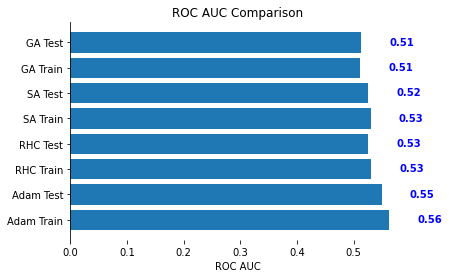

In [3]:
stats = {
        "Adam Train": 0.5624328199300241,
        "Adam Test": 0.5492937617740462,
        "RHC Train": 0.5307354849391381,
        "RHC Test": 0.5255796632241128,
        "SA Train": 0.5299230091245369,
        "SA Test": 0.5247005830288047,
        "GA Train": 0.5113540938584397,
        "GA Test": 0.513575958372122,
    }

names = list(stats.keys())
vals = list(stats.values())

fig, ax = plt.subplots()

ax.barh(names, vals)
for s in ['top', 'bottom', 'right']:
    ax.spines[s].set_visible(False)
for i in ax.patches:
    plt.text(i.get_width()+0.05, i.get_y()+0.3,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='blue')
plt.xlabel("ROC AUC")
plt.title(f"ROC AUC Comparison")
filename = f"nn_roc.png"
plt.savefig(filename, bbox_inches="tight")
plt.show()

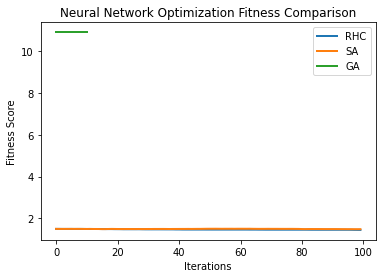

In [3]:
# Plot fitness curves
plt.figure()

for name, a in models:
    fitness = a.fitness_curve
    ys = [x[0] for x in fitness]
    xs = [x for x in range(len(fitness))]
    plt.plot(xs, ys, linewidth=2, label=f"{name}")

plt.ylabel("Fitness Score")
plt.xlabel("Iterations")
plt.title(f"Neural Network Optimization Fitness Comparison")
plt.legend(loc="best")
filename = f"nn-fraud-fitness.png"
plt.savefig(filename, bbox_inches="tight")
plt.show()


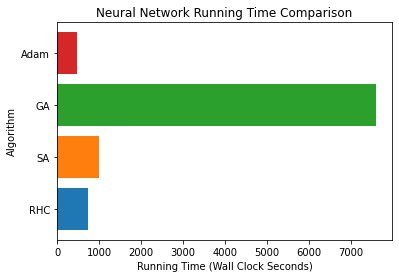

In [13]:
# Plot running times
plt.figure()

times = [['RHC', 735.2085705999634], ['SA', 988.2751076000277], ['GA', 7591.22116429999], ['Adam', 470.04002690000925]]

for label, time in times:
    plt.barh(label, time, label=label)

plt.xlabel("Running Time (Wall Clock Seconds)")
plt.ylabel("Algorithm")
plt.title(f"Neural Network Running Time Comparison")
filename = f"nn-fraud-time.png"
plt.savefig(filename, bbox_inches="tight")
plt.show()